**INTRO + SETUP**

In [ ]:
# Install Kaggle
!pip install -q kaggle

# Create a Kaggle directory
!mkdir -p ~/.kaggle

# Copy the kaggle.json file to the Kaggle directory
!cp kaggle.json ~/.kaggle/

# Change the permissions of the file
!chmod 600 ~/.kaggle/kaggle.json

# Test if the setup is working by listing datasets
!kaggle datasets list


ref                                                                   title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
shreyanshverma27/online-sales-dataset-popular-marketplace-data        Online Sales Dataset - Popular Marketplace Data     7KB  2024-05-25 23:55:26           6091        116  1.0              
rabieelkharoua/cancer-prediction-dataset                              🩺📊 Cancer Prediction Dataset 🌟🔬                    47KB  2024-06-10 03:54:18           1231         25  1.0              
mexwell/pizza-sales                                                   🍕 Pizza Sales                                     586KB  2024-06-06 07:18:22           1534         29  1.0              
informrohit1/smartphones-dataset        

In [ ]:
import re
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print("TPU initialized.")
except Exception as e:
    print("Failed to initialize TPU:", str(e))
    strategy = tf.distribute.get_strategy()  # Default strategy with CPU or single GPU
print("Number of replicas:", strategy.num_replicas_in_sync)

TPU initialized.
Number of replicas: 8


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 25 * strategy.num_replicas_in_sync
IMAGE_SIZE = [180, 180]
CLASS_NAMES = ["NORMAL", "PNEUMONIA"]

**LOAD THE DATA**

In [ ]:
# Download the dataset
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

# Unzip the downloaded dataset
!unzip chest-xray-pneumonia.zip


Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

***MORE LIBS ***

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler, ModelCheckpoint
import matplotlib.pyplot as plt

**Define paths**

In [ ]:
train_dir = '/content/chest_xray/train'
val_dir = '/content/chest_xray/val'
test_dir = '/content/chest_xray/test'

**Define image size and batch size**

In [ ]:
IMAGE_SIZE = [180, 180]
BATCH_SIZE = 32

**Create training, validation, and test datasets**

In [ ]:
train_ds = image_dataset_from_directory(
    train_dir,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'
)

val_ds = image_dataset_from_directory(
    val_dir,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'
)

test_ds = image_dataset_from_directory(
    test_dir,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'
)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


**Apply data augmentation**

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
])

In [ ]:
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)

**Prefetch the datasets for better performance**

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)


**Define the model**

In [ ]:
base_model = EfficientNetB0(input_shape=IMAGE_SIZE + [3], include_top=False, weights='imagenet')
base_model.trainable = False

16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])


**Add callbacks**

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)


**Learning rate scheduler**

In [ ]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)

**Train the model**

In [ ]:
history = model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=[early_stopping, reduce_lr, checkpoint, lr_scheduler])


Epoch 1/10
163/163 [==============================] - ETA: 0s - loss: 0.4246 - accuracy: 0.7949 - precision: 0.8234 - recall: 0.9215

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


163/163 [==============================] - 43s 219ms/step - loss: 0.4246 - accuracy: 0.7949 - precision: 0.8234 - recall: 0.9215 - val_loss: 0.4759 - val_accuracy: 0.6875 - val_precision: 0.6154 - val_recall: 1.0000 - lr: 0.0010
Epoch 2/10
163/163 [==============================] - 35s 211ms/step - loss: 0.3196 - accuracy: 0.8562 - precision: 0.8816 - recall: 0.9316 - val_loss: 0.3784 - val_accuracy: 0.8125 - val_precision: 0.7273 - val_recall: 1.0000 - lr: 0.0010
Epoch 3/10
163/163 [==============================] - 35s 209ms/step - loss: 0.2751 - accuracy: 0.8796 - precision: 0.9048 - recall: 0.9365 - val_loss: 0.3660 - val_accuracy: 0.8125 - val_precision: 0.7273 - val_recall: 1.0000 - lr: 0.0010
Epoch 4/10
163/163 [==============================] - 34s 209ms/step - loss: 0.2668 - accuracy: 0.8867 - precision: 0.9130 - recall: 0.9368 - val_loss: 0.3826 - val_accuracy: 0.8125 - val_precision: 0.7273 - val_recall: 1.0000 - lr: 0.0010
Epoch 5/10
163/163 [==============================]

**Fine-tuning the model**

In [ ]:
base_model.trainable = True
fine_tune_at = len(base_model.layers) - 20

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])

history_fine = model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=[early_stopping, reduce_lr, checkpoint, lr_scheduler])


Epoch 1/10
163/163 [==============================] - 50s 255ms/step - loss: 0.4152 - accuracy: 0.8215 - precision: 0.9546 - recall: 0.7977 - val_loss: 0.2469 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - lr: 1.0000e-05
Epoch 2/10
163/163 [==============================] - 41s 252ms/step - loss: 0.3263 - accuracy: 0.8681 - precision: 0.9518 - recall: 0.8663 - val_loss: 0.2689 - val_accuracy: 0.9375 - val_precision: 0.8889 - val_recall: 1.0000 - lr: 1.0000e-05
Epoch 3/10
163/163 [==============================] - 41s 251ms/step - loss: 0.2930 - accuracy: 0.8817 - precision: 0.9379 - recall: 0.9004 - val_loss: 0.2629 - val_accuracy: 0.9375 - val_precision: 0.8889 - val_recall: 1.0000 - lr: 1.0000e-05
Epoch 4/10
163/163 [==============================] - 43s 259ms/step - loss: 0.2748 - accuracy: 0.8907 - precision: 0.9352 - recall: 0.9164 - val_loss: 0.2405 - val_accuracy: 0.9375 - val_precision: 0.8889 - val_recall: 1.0000 - lr: 1.0000e-05
Epoch 5/10
163/163 [====

**Function to plot training history**

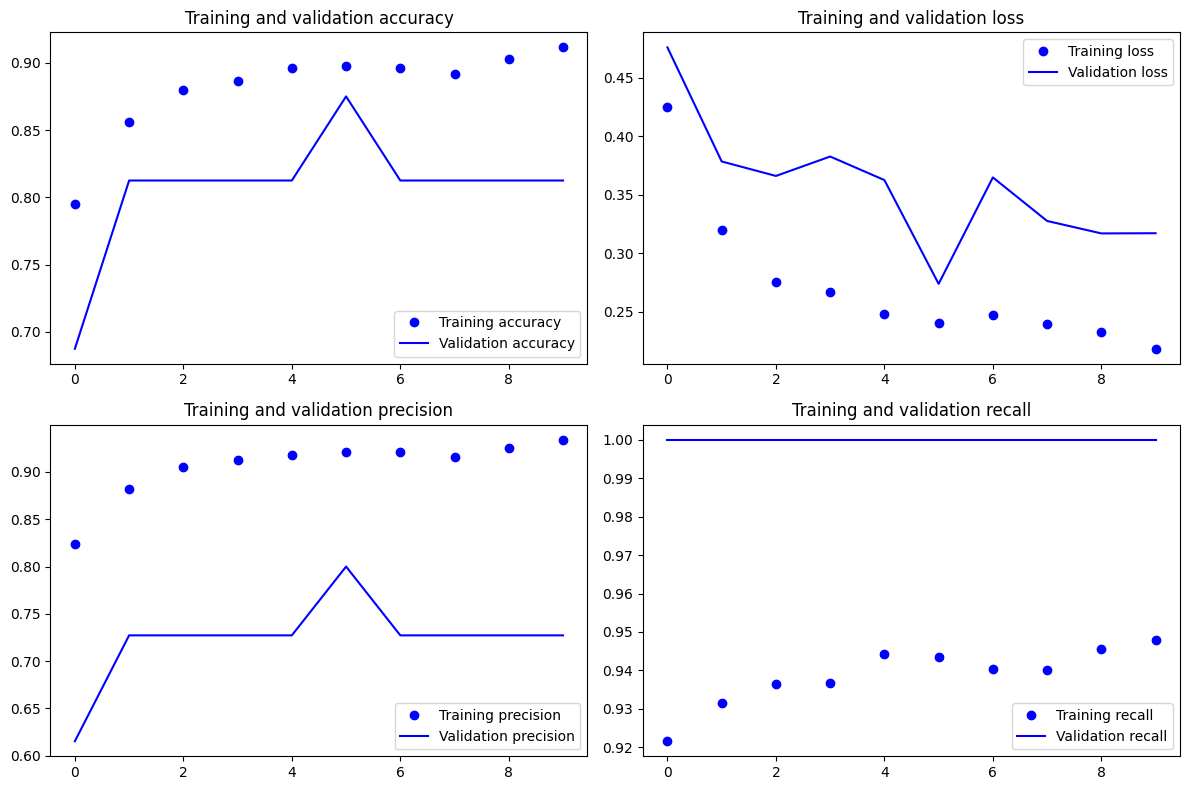

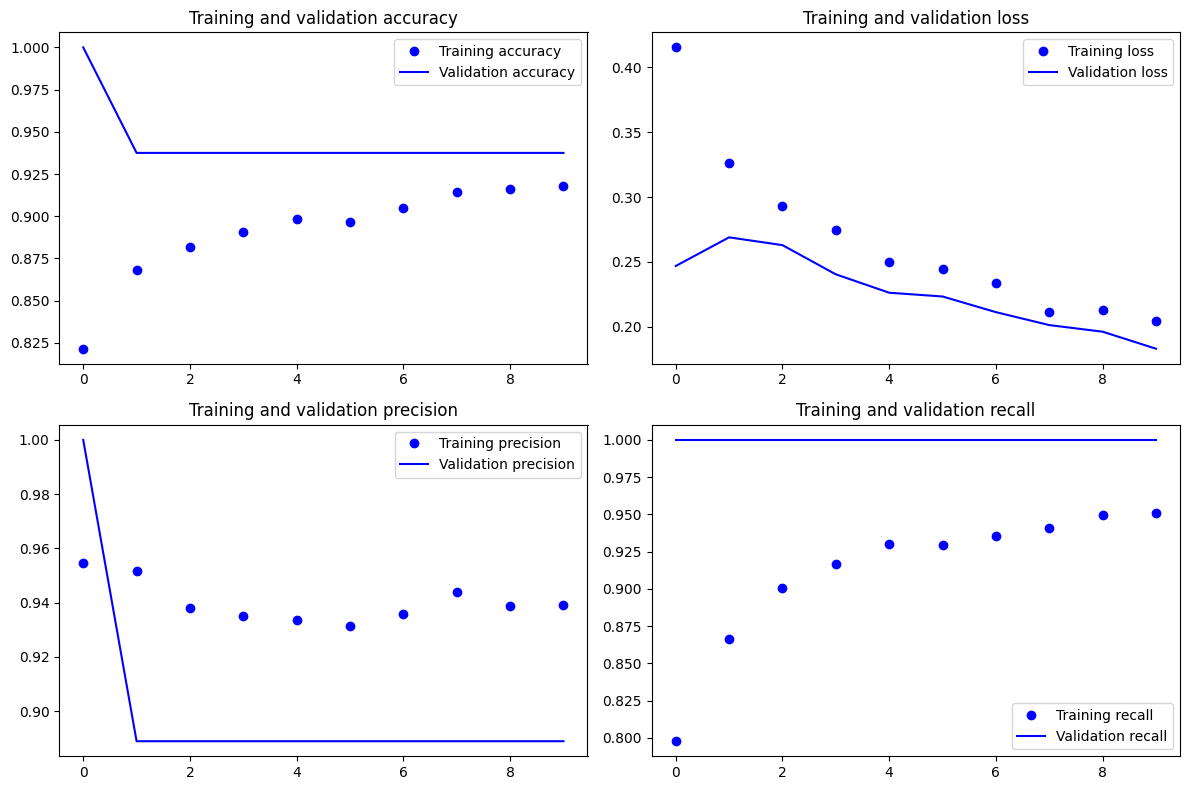

In [ ]:
def plot_training_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    precision = history.history['precision']
    val_precision = history.history['val_precision']
    recall = history.history['recall']
    val_recall = history.history['val_recall']

    epochs = range(len(acc))

    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(epochs, precision, 'bo', label='Training precision')
    plt.plot(epochs, val_precision, 'b', label='Validation precision')
    plt.title('Training and validation precision')
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(epochs, recall, 'bo', label='Training recall')
    plt.plot(epochs, val_recall, 'b', label='Validation recall')
    plt.title('Training and validation recall')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history, 'Initial Training and Validation Metrics')
plot_training_history(history_fine, 'Fine-Tuning Training and Validation Metrics')


**Display final metrics**

In [ ]:
initial_train_acc = history.history['accuracy'][-1]
initial_val_acc = history.history['val_accuracy'][-1]
initial_train_precision = history.history['precision'][-1]
initial_val_precision = history.history['val_precision'][-1]
initial_train_recall = history.history['recall'][-1]
initial_val_recall = history.history['val_recall'][-1]

fine_tune_train_acc = history_fine.history['accuracy'][-1]
fine_tune_val_acc = history_fine.history['val_accuracy'][-1]
fine_tune_train_precision = history_fine.history['precision'][-1]
fine_tune_val_precision = history_fine.history['val_precision'][-1]
fine_tune_train_recall = history_fine.history['recall'][-1]
fine_tune_val_recall = history_fine.history['val_recall'][-1]

In [ ]:
print(f"Initial Training Accuracy: {initial_train_acc:.4f}, Validation Accuracy: {initial_val_acc:.4f}")
print(f"Initial Training Precision: {initial_train_precision:.4f}, Validation Precision: {initial_val_precision:.4f}")
print(f"Initial Training Recall: {initial_train_recall:.4f}, Validation Recall: {initial_val_recall:.4f}")

print(f"Fine-Tuning Training Accuracy: {fine_tune_train_acc:.4f}, Validation Accuracy: {fine_tune_val_acc:.4f}")
print(f"Fine-Tuning Training Precision: {fine_tune_train_precision:.4f}, Validation Precision: {fine_tune_val_precision:.4f}")
print(f"Fine-Tuning Training Recall: {fine_tune_train_recall:.4f}, Validation Recall: {fine_tune_val_recall:.4f}")


Initial Training Accuracy: 0.9114, Validation Accuracy: 0.8125
Initial Training Precision: 0.9339, Validation Precision: 0.7273
Initial Training Recall: 0.9479, Validation Recall: 1.0000
Fine-Tuning Training Accuracy: 0.9179, Validation Accuracy: 0.9375
Fine-Tuning Training Precision: 0.9391, Validation Precision: 0.8889
Fine-Tuning Training Recall: 0.9512, Validation Recall: 1.0000


**Load the best saved model**

In [ ]:
best_model = tf.keras.models.load_model('best_model.h5')

**Evaluate the model on the test set**

In [ ]:
test_loss, test_accuracy, test_precision, test_recall = best_model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

20/20 [==============================] - 6s 207ms/step - loss: 0.3166 - accuracy: 0.8542 - precision: 0.8485 - recall: 0.9333
Test Accuracy: 0.8542
Test Precision: 0.8485
Test Recall: 0.9333


**OUTPUT**

1/1 [==============================] - 0s 258ms/step


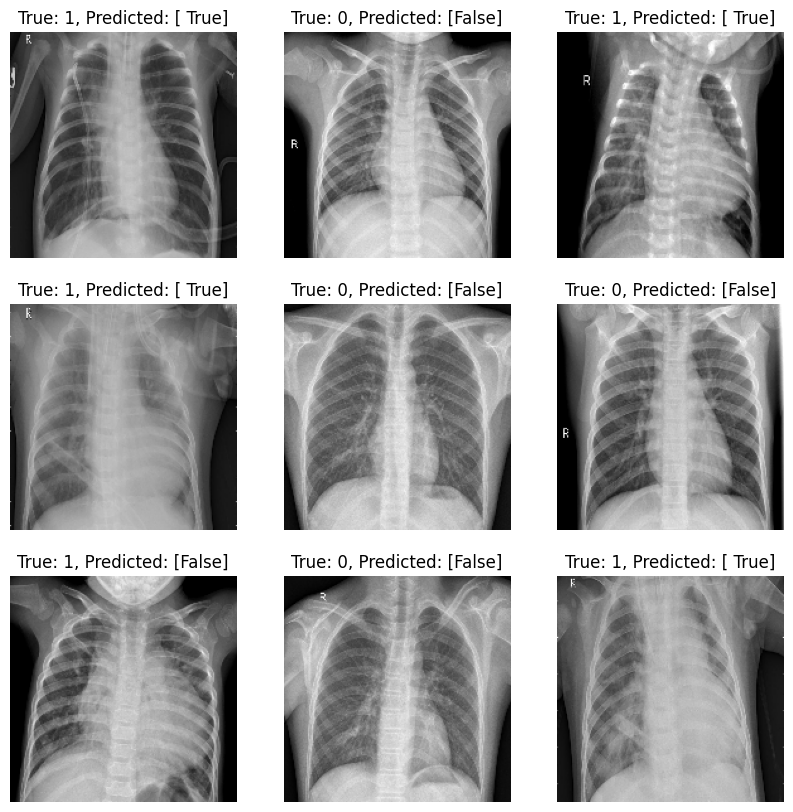

In [ ]:
import matplotlib.pyplot as plt

# Initialize a counter to keep track of displayed images
displayed_images = 0

# Iterate over the test dataset and make predictions
for images, labels in test_ds:
    predictions = model.predict(images)  # Assuming 'model' is your trained model
    predicted_labels = predictions > 0.5  # Assuming binary classification with a threshold of 0.5

    # Plot the images along with their predicted labels
    plt.figure(figsize=(10, 10))
    for i in range(len(images)):
        if displayed_images >= 9:  # Check if we have displayed enough images
            break

        plt.subplot(3, 3, displayed_images + 1)  # Adjust the subplot grid to 3x3
        plt.imshow(images[i].numpy().astype("uint8"))  # Convert images to uint8 for plotting
        plt.title(f"True: {labels[i].numpy()}, Predicted: {predicted_labels[i]}")
        plt.axis("off")

        displayed_images += 1

    if displayed_images >= 9:  # Check if we have displayed enough images
        break

plt.show()


**ADDITIONAL GRAPHS**

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc


Learning Curve

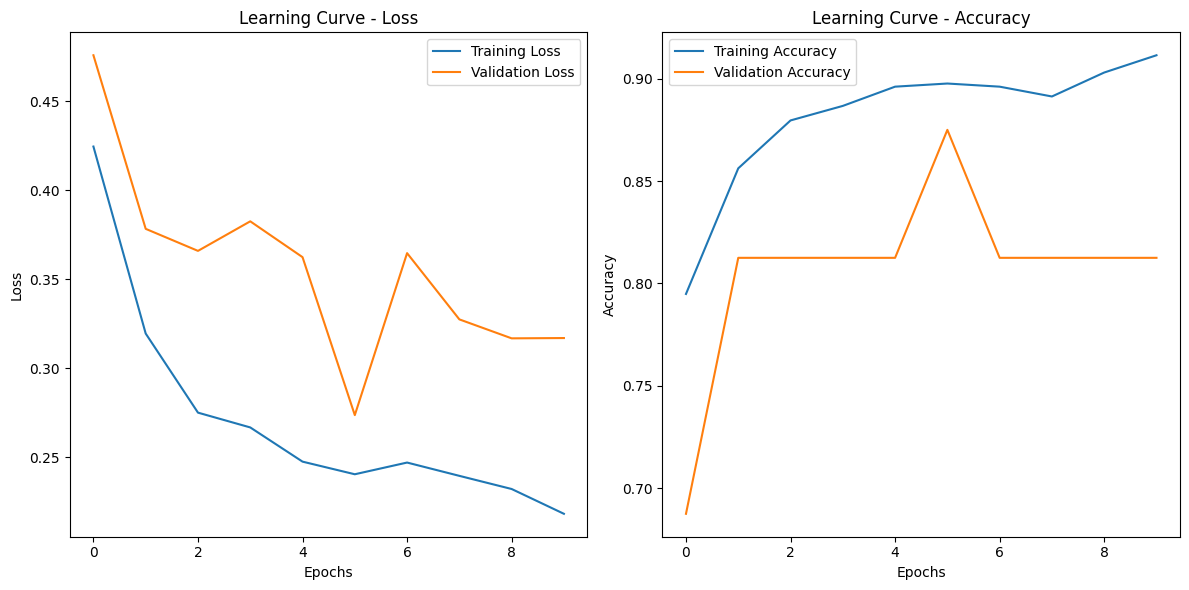

In [ ]:
def plot_learning_curve(history):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Learning Curve - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Learning Curve - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_learning_curve(history)

ROC Curve

1/1 [==============================] - 1s 1s/step


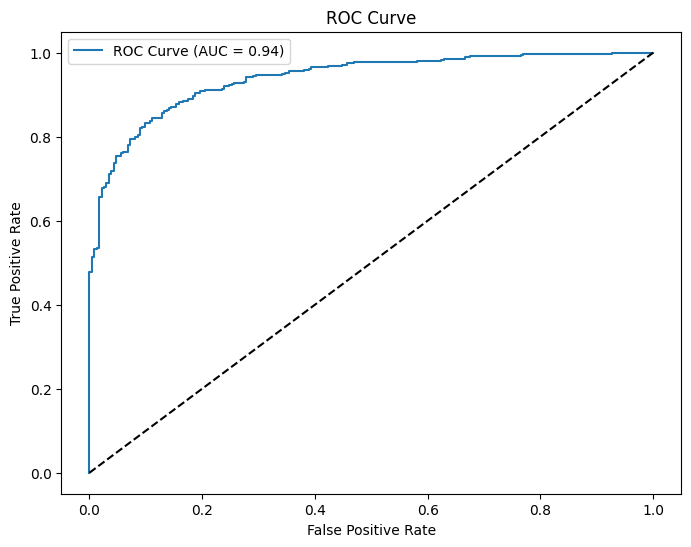

In [ ]:
def plot_roc_curve(y_true, y_prob):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc_score = roc_auc_score(y_true, y_prob)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

y_test = []
y_prob = []
for images, labels in test_ds:
    y_test.extend(labels.numpy())
    y_prob.extend(best_model.predict(images).flatten())

plot_roc_curve(y_test, y_prob)

Precision-Recall Curve

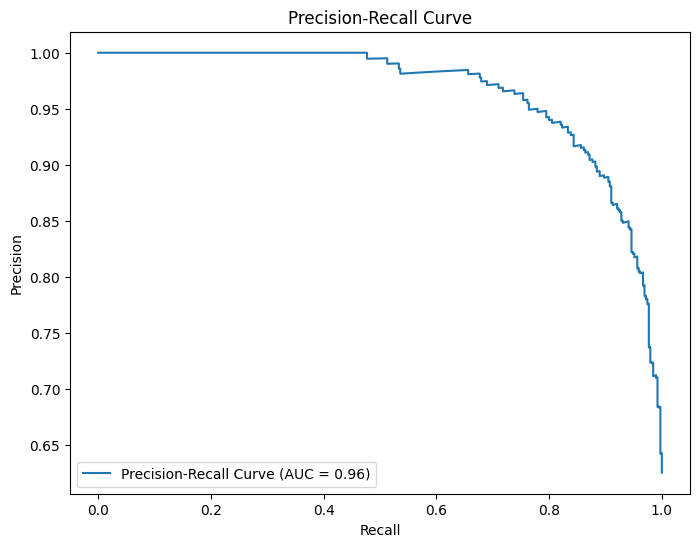

In [ ]:
def plot_precision_recall_curve(y_true, y_prob):
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(recall, precision)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'Precision-Recall Curve (AUC = {pr_auc:.2f})')
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.show()

plot_precision_recall_curve(y_test, y_prob)

Loss Curve

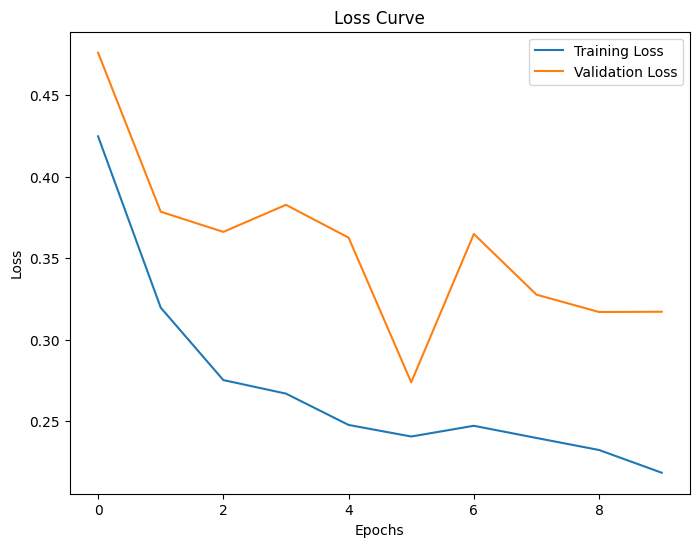

In [ ]:
def plot_loss_curve(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss_curve(history)